### External Sources and packages
Below cell lists the external dependencies of this notebook. I have utilized current well known third party libraries such as:

- pandas https://pandas.pydata.org/
- sklearn https://scikit-learn.org/

<br>I have kept the usage of external librairies varied to keep the tasks simplistic and easy to explain and to demonstrate my understanding and usage of the same. For generating graphs and charts:

- matplotlib https://matplotlib.org

In [1]:
import base64
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline

from pprint import pprint
from collections import Counter

print ("all imports worked nicely")

all imports worked nicely


### Data Exploration
1. Parsing the file into a Pandas dataframe
2. Checking some of the values for individual columns - entities, id and words
3. Understanding the substructure of complex json types: entities and words. Creating sub dataframes from them.

In [2]:
pd.set_option('display.max_colwidth', 100)
df = pd.read_json("data/test.json", orient='columns')
# df.describe
df.head(5)

,entities,id,words
0,"[{'metaData': {'region': {'page': 1}}, 'label': 'item', 'indices': [74]}]",156033512,"[{'value': 'cVuUnaOUoZY=', 'region': {'left': 0.212656784492588, 'top': 0.039935457845905006, 'w..."
1,"[{'metaData': {'region': {'page': 1}}, 'label': 'item', 'indices': [81, 82, 83, 84, 85, 86]}]",253055966,"[{'value': 'fXt2fIV6dImE', 'region': {'left': 0.5992750704792591, 'top': 0.040011431837667005, '..."
2,"[{'metaData': {'region': {'page': 1}}, 'label': 'item', 'indices': [21, 22, 23, 24, 25]}]",456561110,"[{'value': 'gqeUrQ==', 'region': {'left': 0.272268907563025, 'top': 0.032104637336504004, 'width..."
3,"[{'metaData': {'region': {'page': 1}}, 'label': 'item', 'indices': [79]}]",391044810,"[{'value': 'hGA=', 'region': {'left': 0.104333868378812, 'top': 0.04519613416714, 'width': 0.045..."
4,"[{'metaData': {'region': {'page': 1}}, 'label': 'item', 'indices': [71, 72]}]",427645549,"[{'value': 'e4I=', 'region': {'left': 0.7173202614379081, 'top': 0.050505050505050005, 'width': ..."


In [3]:
# further exploring "words" json object
words_column_list = df["words"].tolist()

df_words = pd.DataFrame(words_column_list[0])
df_words.head()

,region,value
0,"{'left': 0.212656784492588, 'top': 0.039935457845905006, 'width': 0.122576966932725, 'height': 0...",cVuUnaOUoZY=
1,"{'left': 0.705815279361459, 'top': 0.044776119402985, 'width': 0.03933865450399, 'height': 0.013...",cpullp-U
2,"{'left': 0.7494298745724061, 'top': 0.044776119402985, 'width': 0.038768529076396004, 'height': ...",naSYoJKglw==
3,"{'left': 0.6393956670467501, 'top': 0.070189592577652, 'width': 0.020524515393386, 'height': 0.0...",hZqY
4,"{'left': 0.6639110604332951, 'top': 0.070189592577652, 'width': 0.07611174458380801, 'height': 0...",iJOnmaOflKaip5g=


In [4]:
# need json_normalize to split the complex json types in sub-columns
import json
from pandas.io.json import json_normalize
#load json object
with open('data/train.json') as f:
    d = json.load(f)

In [5]:
len(d)

24073

In [6]:
# splitting the data-set on entities column
# retain the relation with words and id column

entities_data = json_normalize(data=d, record_path= ['entities'], 
                            meta=['words', 'id'])
entities_data.tail(5)

,indices,label,metaData,words,id
63340,"[68, 69, 70, 71, 72]",item,{'region': {'page': 1}},"[{'value': 'hQ==', 'region': {'left': 0.5142857142857142, 'top': 0.06294536817102138, 'width': 0...",126908410
63341,"[50, 51, 52, 53, 54]",item,{'region': {'page': 1}},"[{'value': 'YmRiaGBkY2Vo', 'region': {'left': 0.031936127744510975, 'top': 0.027822580645161292,...",370155188
63342,"[48, 49, 50, 51, 52, 53, 54, 55, 56]",item,{'region': {'page': 1}},"[{'value': 'fZuVmaOmrA==', 'region': {'left': 0.12773109243697478, 'top': 0.09026128266033254, '...",103014394
63343,"[29, 30]",item,{'region': {'page': 1}},"[{'value': 'f5ufpw==', 'region': {'left': 0.11932773109243698, 'top': 0.8680142687277052, 'width...",187175422
63344,"[65, 66, 67]",item,{'region': {'page': 1}},"[{'value': 'gy6Wn52TpqiklZummpin', 'region': {'left': 0.09411764705882353, 'top': 0.337292161520...",510220123


In [7]:
# generating data for downstream model training and evaluation tasks 

train_id = entities_data['id'].tolist()
train_indices = entities_data['indices'].tolist()
train_words = entities_data["words"]

print (len(train_id), len(train_indices), len(train_words))

63345 63345 63345


In [8]:
# Params: 
# words_list : word object from train_words list
# indice_list : indice object from train_indices
# return : a list of labels for each word in word_list
#  label 0 : if the word was NOT relevant item
#  label 1 : if the word was relevant item, it's index was contained in indices_list

def get_label(words_list,indices_list):
    labels = []
    for i in range(0,len(words_list)):
        if (i in indices_list):
            labels.append(1)
        else:
            labels.append(0)
    return labels

### Parsing the data for downstream model training and evaluation tasks
Extracting three KEY aspects of data in the form of list objects from source:
1. **words_region[]** information
2. **words_value[]** information
3. **words_label[]** information

In [9]:
train_word_labels = []
index = 0
for words in train_words:
    train_word_labels.append(get_label(words, train_indices[index]))
    index += 1

In [10]:
# sanity check on the extracted data
# 

print (len(train_word_labels))
print (train_word_labels[0])
print (train_indices[0])

positive_indices = np.nonzero(train_word_labels[0])[0]

print (positive_indices)

# flattening the labels list 
train_word_labels_flatten = [item for sublist in train_word_labels for item in sublist]

print (len(train_word_labels_flatten))
print (train_word_labels_flatten[:121])

63345
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [11]:
flatten_word_dict = [item for sublist in train_words for item in sublist]
print (len(flatten_word_dict))
print (flatten_word_dict[0])

23813853
{'value': 'U1Raiug=', 'region': {'left': 0.3712528823981553, 'top': 0.020022246941045607, 'width': 0.025749423520368946, 'height': 0.015016685205784204, 'page': '1'}}


In [12]:
train_word_values = [word["value"] for word in flatten_word_dict]
train_word_position = [word["region"] for word in flatten_word_dict]

print (len(train_word_values), len(train_word_position), len(train_word_labels_flatten))

23813853 23813853 23813853


In [13]:
train_word_position_df = pd.DataFrame(train_word_position[:1000])
train_word_position_df.head()

,height,left,page,top,width
0,0.015017,0.371253,1,0.020022,0.025749
1,0.028087,0.345503,1,0.033092,0.224058
2,0.017798,0.345503,1,0.050334,0.039201
3,0.005840,0.406995,1,0.062291,0.048040
4,0.005562,0.463874,1,0.062291,0.007302


In [14]:
train_data_sample = [('region', train_word_position[:1000]),
         ('value', train_word_values[:1000]),
         ('label', train_word_labels_flatten[:1000]),
         ]
df = pd.DataFrame.from_items(train_data_sample)
df.head(5)

/home/rshringi/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  """


,region,value,label
0,"{'left': 0.3712528823981553, 'top': 0.020022246941045607, 'width': 0.025749423520368946, 'height...",U1Raiug=,0
1,"{'left': 0.34550345887778633, 'top': 0.03309232480533927, 'width': 0.22405841660261339, 'height'...",WC8whnZ1fnk=,0
2,"{'left': 0.34550345887778633, 'top': 0.050333704115684094, 'width': 0.03920061491160646, 'height...",Lg==,0
3,"{'left': 0.4069946195234435, 'top': 0.06229143492769744, 'width': 0.048039969254419675, 'height'...",d354fYR1ew==,0
4,"{'left': 0.4638739431206764, 'top': 0.06229143492769744, 'width': 0.007302075326671791, 'height'...",Vw==,0


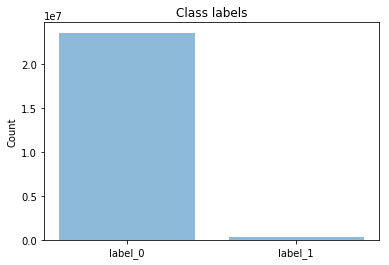

In [15]:
# checking for class distribution : class imbalance?
from collections import Counter
class_distribution = Counter(train_word_labels_flatten)

objects = ('label_0', 'label_1')
y_pos = np.arange(len(objects))
performance = [class_distribution[0], class_distribution[1]]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Count')
plt.title('Class labels')

plt.show()

In [16]:
# Preparing test-data set:
# similar method as train-data set

with open('data/test.json') as json_file:  
    data = json.load(json_file)

# splitting the data-set on entities column
# retain the relation with words and id column

entities_data = json_normalize(data=data, record_path= ['entities'], 
                            meta=['words', 'id'])
entities_data.tail(5)
test_id = entities_data['id'].tolist()
test_indices = entities_data['indices'].tolist()
test_words = entities_data["words"]

print ("Sanity Check, length of test_id:%d,test_indices:%d,test_words:%d" % (len(test_id), 
        len(test_indices), len(test_words)))


# extract the labels:

test_word_labels = []
index = 0
for words in test_words:
    test_word_labels.append(get_label(words, test_indices[index]))
    index += 1

# flattening the labels list 
test_word_labels_flatten = [item for sublist in test_word_labels for item in sublist]
flatten_word_dict = [item for sublist in test_words for item in sublist]

test_word_values = [word["value"] for word in flatten_word_dict]
test_word_position = [word["region"] for word in flatten_word_dict]

print ("Sanity Check flattened data, length of test_word_values:%d,test_word_position:%d,test_words_labels:%d"
       % (len(test_word_values), len(test_word_position), len(test_word_labels_flatten)))

Sanity Check, length of test_id:2108,test_indices:2108,test_words:2108
Sanity Check flattened data, length of test_word_values:759967,test_word_position:759967,test_words_labels:759967


In [17]:
test_data_sample = [('region', test_word_position[:1000]),
         ('value', test_word_values[:1000]),
         ('label', test_word_labels_flatten[:1000]),
         ]
df = pd.DataFrame.from_items(test_data_sample)
df.head()

/home/rshringi/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  """


,region,value,label
0,"{'left': 0.21265678449258837, 'top': 0.03993545784590561, 'width': 0.1225769669327252, 'height':...",cVuUnaOUoZY=,0
1,"{'left': 0.7058152793614595, 'top': 0.04477611940298507, 'width': 0.03933865450399088, 'height':...",cpullp-U,0
2,"{'left': 0.749429874572406, 'top': 0.04477611940298507, 'width': 0.03876852907639681, 'height': ...",naSYoJKglw==,0
3,"{'left': 0.6393956670467503, 'top': 0.07018959257765228, 'width': 0.020524515393386546, 'height'...",hZqY,0
4,"{'left': 0.6639110604332953, 'top': 0.07018959257765228, 'width': 0.07611174458380844, 'height':...",iJOnmaOflKaip5g=,0


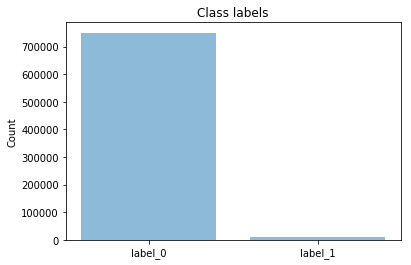

In [18]:
# checking for class distribution : class imbalance? in test-data 
from collections import Counter
class_distribution = Counter(test_word_labels_flatten)

objects = ('label_0', 'label_1')
y_pos = np.arange(len(objects))
performance = [class_distribution[0], class_distribution[1]]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Count')
plt.title('Class labels')

plt.show()

### Inferences :
1. High **class imbalance** is evident in both train and test data set.
2. "accuracy" NOT being the correct measure of model preformance in this case.
3. **Precision, Recall** and combination methods **f-measure** should be utilized, **confusion matrix** must be generated.
4. Need to **Upsample**(low class frequency data) or **Downsample**(high class frequency data) to train a model.

### Downsampling data:
- getting a list of indices for all items with class 1
- getting a comparable size of list of indices of iteems with class 0, thus **removing class imbalance**
- using the data from these items to train a model

In [19]:
def downsample_data(train_word_labels):
    indices_total = [item for item in range(0, len(train_word_labels))]
    
    indices_class_1 = np.nonzero(train_word_labels)[0] # get the index of items with label 1
    print ("number of items with Class 1 %d" % len(indices_class_1))
    print ("index of first 10 words with class label 1 %s" % indices_class_1[:10])
    
    margin = 5000 # variable to iterate over base data
    
    # iterate over the length of minority class items(with added margin) and get items which are not in class 1 
    indices_class_0 = [item for item in range(0, (len(indices_class_1) + margin)) if item not in indices_class_1]
    print ("number of items with Class 0 %d" % len(indices_class_0))
    print ("index of first 10 words with class label 0 %s" % indices_class_0[:10])
    
    return indices_class_1, indices_class_0    

In [22]:
indices_class_1, indices_class_0 = downsample_data(train_word_labels_flatten)

number of items with Class 1 288667
index of first 10 words with class label 1 [ 117  118  119  530  531  532  533  939 1345 1346]
number of items with Class 0 289775
index of first 10 words with class label 0 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


## Next Steps:

### Algorithm (based on region data):
- Since we have the "region" information of useful "items" on the page, we need to train a classifier to take this information as input and predict if the text in that region is useful item or not.

- As th region information is a **bounding box**(collection of straight lines) a **logistic regression** model or ensemble of a few logistic regression models should predict the output with acceptable performance

- **Reason for logistic regression** : the input data intutively seems to be linearly separable thus a linear regression can be used BUT the **output is (binary)class probabilites** instead of real valued numbers thus a logistic regression method seems like a good choice to start with. 

- **KNN**: k nearest neighbour is another method that can be explored. As the data points are spatial points, we can classify a region marked by a group of points(co-ordinates of bounding box) by it's k nearest neighbors.

### Algorithm (based on NLP):
- **NLP add-on**: in the ideal case a model that compares the text-similarity between useful "items" can be placed on top of region based model to increase the performance. 

1. Since the items in a set of domain specific invoices will tend to fall in a similar category their similarity among eachother will be high.

2. **(text)Similarity** between useful items and un-useful items from OCR should be low as the un-useful items would be extra(item-unrelated) information captured by OCR. For example: a set of related items for a medical invoice could be medicines and medicinal equipments(bandages, syringes etc.), while un-related items picked by OCR can be extra details on the invoice such hospital address, contact information. 

3. As the item value is **anonymized** here, moving forward in that direction is difficult as the **linguistic information** that is used when using **word** (or group of words) **embeddings** is lost in anonymization.

### Questions to think about:
* **What is good measure for classification accuracy?**
    * Either we make the class distribution fairly uniform in train and test data using upsample or downsample technique and then check model accuracy
    * or we check Precision, Recall(True positive rate) and area under the curve for ROC graph
* **What are possible shortcomings and extensions of your implementation?**
    * I am mostly inclined towards training an ensemble of linear models or a K-nearest neighbor classifier
    * Shortcomings: since both the above methods just take "region" information in account, they depend on **clear regional separation** of useful items from un-useful ones
    * This assumption fails if there's **considerable overlap** in regional positions of two classes
    * **Extension**: A NLP(text-similarity) model as described above.
* **How would you design a real-time performance system that responds to a high volume of prediction requests efficiently.**
    * Idea will be to aim for - high throughput, low latency and near-real time predictions with acceptable error margin.
    * Keeping the design such that data ingestion(cleanning, pre-processing, data-distribution), model training and prediction and real-time request processing are well sperated modules.
    * **Ideally**:
        * specify performance-metrics (NOT accuracy in our case)
        * serialized model weigths/parameters and keep separate from prediction module
        * automated sanity tests(regression tests) to keep check of failures while updating to a new model
        * since the "domain" specific invoices tend to keep a fairly fixed structure, I am not sure if nightly updates are required for the model. If YES then a module for "historical data test" as baseline tests and "latest data tests" should be kept in place in order to get an **early warning**
        * rolling out the new updated model in beta releases or limited users and collect feedback on predictions. Move to updated model once it meets minimum base requirements and improves on earlier model results
        
### Feedback:
- the problem statement is really interesting and I enjoyed exploring and working on possible solutions
- due to the given **time constraint of 4 hours**, I could only proceed so far. Given more time and "non-anonymized" data some more quick solutions could be explored.
